1. Вам нужно будет загрузить и оформить датасет котиков, собак https://www.kaggle.com/andrewmvd/dog-and-cat-detection
2. *Нужно будет произвести аугментацию данных

3. Затем обучить нейронную сеть на получившемся датасете

In [86]:
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-7gmbqpzo
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-7gmbqpzo


In [87]:
# Download TorchVision repo to use some files from
# references/detection
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

!cp ./vision/references/detection/utils.py ./
!cp ./vision/references/detection/transforms.py ./
!cp ./vision/references/detection/coco_eval.py ./
!cp ./vision/references/detection/engine.py ./
!cp ./vision/references/detection/coco_utils.py ./

fatal: destination path 'vision' already exists and is not an empty directory.
fatal: not a git repository (or any parent up to mount point /kaggle)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [88]:
import os
import random

import numpy as np
import pandas as pd

import cv2

from PIL import Image, ImageDraw
from seaborn import color_palette

from pathlib import Path
from xml.etree import ElementTree

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset

import torchvision

from engine import train_one_epoch, evaluate
import utils
import transforms as T

In [89]:
images_path = '../input/dog-and-cat-detection/images'
annotations_path = '../input/dog-and-cat-detection/annotations'

In [90]:
def parse_xml(files_path):
    
    annotations_list = []
    
    for path in files_path:
        
        annotation_dict = {}
        
        root = ElementTree.parse(path).getroot()
        
        annotation_dict['filename'] = Path(images_path + '/' + root.find('./filename').text)
        
        annotation_dict['width'] = int(root.find('./size/width').text)
        annotation_dict['height'] = int(root.find('./size/height').text)
        
        annotation_dict['class'] = root.find('./object/name').text
        
        annotation_dict['xmin'] = int(root.find('./object/bndbox/xmin').text)
        annotation_dict['ymin'] = int(root.find('./object/bndbox/ymin').text)
        annotation_dict['xmax'] = int(root.find('./object/bndbox/xmax').text)
        annotation_dict['ymax'] = int(root.find('./object/bndbox/ymax').text)
        
        annotations_list.append(annotation_dict)
    
    dataframe = pd.DataFrame(annotations_list)
    
    return dataframe

In [91]:
df = parse_xml(list(Path(annotations_path).glob('*.xml')))

In [92]:
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,../input/dog-and-cat-detection/images/Cats_Tes...,313,310,cat,99,34,238,183
1,../input/dog-and-cat-detection/images/Cats_Tes...,500,417,dog,183,92,291,259
2,../input/dog-and-cat-detection/images/Cats_Tes...,500,375,dog,155,119,356,250
3,../input/dog-and-cat-detection/images/Cats_Tes...,500,375,dog,193,85,305,179
4,../input/dog-and-cat-detection/images/Cats_Tes...,500,334,dog,284,58,363,128


In [93]:
vc = df['class'].value_counts()
vc

dog    2498
cat    1188
Name: class, dtype: int64

In [94]:
classes_dict = dict(zip(vc.keys().to_list(), np.arange(vc.shape[0])))
classes_dict

{'dog': 0, 'cat': 1}

In [95]:
class_num_to_name = dict(zip(np.arange(vc.shape[0]), vc.keys().to_list()))
class_num_to_name

{0: 'dog', 1: 'cat'}

In [96]:
df['class'] = df['class'].apply(lambda x: classes_dict[x])

In [97]:
df['class'] = df['class'].astype(np.uint8)

In [98]:
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,../input/dog-and-cat-detection/images/Cats_Tes...,313,310,1,99,34,238,183
1,../input/dog-and-cat-detection/images/Cats_Tes...,500,417,0,183,92,291,259
2,../input/dog-and-cat-detection/images/Cats_Tes...,500,375,0,155,119,356,250
3,../input/dog-and-cat-detection/images/Cats_Tes...,500,375,0,193,85,305,179
4,../input/dog-and-cat-detection/images/Cats_Tes...,500,334,0,284,58,363,128


In [99]:
def conver_an_image_colo_to_rgb(image):
    
    change_color_from_to = cv2.COLOR_BGR2RGB
    converted_colors_image = cv2.cvtColor(image, change_color_from_to)
    
    return converted_colors_image

def read_image(image_path):
    
    image = cv2.imread(str(image_path))
    
    image = conver_an_image_colo_to_rgb(image)
    
    return image

def bb2mask(im, bb):
    
    """Конвертируем bounding box в маску"""
    
    mask = np.zeros(im.shape[:-1])
    bb = bb.astype(np.int)
    x_min, y_min, x_max, y_max = bb
    mask[y_min:y_max + 1, x_min:x_max + 1] = 1
    
    return mask

def mask2bb(mask):
    
    """Конвертируем маску в bounding box, принимая 0 как фоновый ненулевой объект"""
    
    cols, rows = np.nonzero(mask)
    
    if len(cols) == 0: 
        return np.zeros(4, dtype=np.float32)
    
    x_min = np.min(rows)
    y_min = np.min(cols)
    x_max = np.max(rows)
    y_max = np.max(cols)
    
    return np.array([x_min, y_min, x_max, y_max], dtype=np.float32)

In [100]:
def resize_an_image(image_path, write_path, bb, new_size):
    
    image = read_image(image_path)
    mask = bb2mask(image, bb)
    
    resized_image = cv2.resize(image, (new_size, new_size))
    resized_mask = cv2.resize(mask, (new_size, new_size))
    
    new_image_path = Path(str(write_path) + '/' + image_path.parts[-1])
    
    cv2.imwrite(str(new_image_path), conver_an_image_colo_to_rgb(resized_image))
    
    new_bb = mask2bb(resized_mask)
    
    return new_image_path, new_bb

In [101]:
def draw_box(image_path, bb, cl, cl_dict):
    
    color = (np.array(color_palette('hls', 1)) * 255).astype(np.uint8)[0]
    
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)
    draw.rectangle(bb, outline=tuple(color), width=3)
    
    text = f"{cl_dict[cl].upper()}"
    text_size = draw.textsize(text)
    
    text_x, text_y = text_size
    
    x_min, y_min = bb[:2]
    
    text_box_xy = [x_min, y_min + text_y, x_min + text_x, y_min]
    text_xy = [x_min, y_min]
    
    draw.rectangle(text_box_xy, fill=tuple(color))
    draw.text(text_xy, text, fill='white')
    
    return image

In [102]:
resized_images_folder = Path('resized_images')

image_path_column = 'filename'
bb_columns = ['xmin', 'ymin', 'xmax', 'ymax']

IMG_SIZE = 300

In [103]:
def add_to_df_new_cols(x, write_path, new_size):

    image_path = x[image_path_column]
    bb = x[bb_columns].values
    
    new_path, new_bb = resize_an_image(image_path, write_path, bb, new_size)
    
    x['new_path'] = new_path
    x['new_bb'] = new_bb
    
    return x

In [104]:
Path.mkdir(resized_images_folder, exist_ok=True)

In [105]:
df = df.apply(lambda x: add_to_df_new_cols(x, resized_images_folder, IMG_SIZE), axis=1)

In [106]:
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,new_path,new_bb
0,../input/dog-and-cat-detection/images/Cats_Tes...,313,310,1,99,34,238,183,resized_images/Cats_Test2888.png,"[94.0, 32.0, 229.0, 178.0]"
1,../input/dog-and-cat-detection/images/Cats_Tes...,500,417,0,183,92,291,259,resized_images/Cats_Test1617.png,"[110.0, 66.0, 174.0, 186.0]"
2,../input/dog-and-cat-detection/images/Cats_Tes...,500,375,0,155,119,356,250,resized_images/Cats_Test83.png,"[93.0, 95.0, 213.0, 200.0]"
3,../input/dog-and-cat-detection/images/Cats_Tes...,500,375,0,193,85,305,179,resized_images/Cats_Test899.png,"[116.0, 68.0, 183.0, 143.0]"
4,../input/dog-and-cat-detection/images/Cats_Tes...,500,334,0,284,58,363,128,resized_images/Cats_Test1204.png,"[170.0, 52.0, 218.0, 115.0]"


In [107]:
df = df.reset_index()

In [108]:
X = df[['new_path', 'new_bb']]
y = df['class']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [109]:
def image_normalize(image):
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    
    image -= imagenet_stats[0]
    image /= imagenet_stats[1]
    
    return image

In [110]:
# Вырезаем кусок с изображения
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

# Центральное вырезание 
def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)

def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT):
    """ Поворачиваем наше изображение"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M, (c, r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im, M, (c, r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS)

def random_cropXY(x, Y, r_pix=8):
    """ Возвращает случайное вырезание"""
    r, c,*_ = x.shape
    c_pix = round(r_pix * c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2 * rand_r * r_pix).astype(int)
    start_c = np.floor(2 * rand_c * c_pix).astype(int)
    xx = crop(x, start_r, start_c, r - 2*r_pix, c - 2*c_pix)
    YY = crop(Y, start_r, start_c, r - 2*r_pix, c - 2*c_pix)
    return xx, YY

# Трансформируем нашу картинку 
def transformsXY(path, bb, is_transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB) / 255
    Y = bb2mask(x, bb)
    if is_transforms:
        rdeg = (np.random.random()-.50) * 20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask2bb(Y)

def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

In [111]:
class CatDogDataset(Dataset):
    
    def __init__(self, paths, bbs, classes, is_transforms=False):
        self.paths = paths.values
        self.bbs = bbs.values
        self.classes = classes.values
        self.is_transforms = is_transforms
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        
        path = self.paths[idx]
        y_class = self.classes[idx]
        bb = self.bbs[idx]
        
        x, y_bb = transformsXY(path, bb, self.is_transforms)
        x = image_normalize(x)
        x = np.rollaxis(x, 2)
        
        return x, y_class, y_bb

In [112]:
class CatsDogsNet(nn.Module):
    def __init__(self):
        super(CatsDogsNet, self).__init__()
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1, padding_mode='zeros')
        self.bn1 = nn.BatchNorm2d(8)
        
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, padding_mode='zeros')
        self.bn2 = nn.BatchNorm2d(16)
        
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, padding_mode='zeros')
        self.bn3 = nn.BatchNorm2d(32)
        
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, padding_mode='zeros')
        self.bn4 = nn.BatchNorm2d(64)
        
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, padding_mode='zeros')
        self.bn5 = nn.BatchNorm2d(128)
        
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, padding_mode='zeros')
        self.bn6 = nn.BatchNorm2d(256)
        
        self.conv7 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, padding_mode='zeros')
        self.bn7 = nn.BatchNorm2d(512)
        
        self.conv8 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1, padding_mode='zeros')
        self.bn8 = nn.BatchNorm2d(1024)
        
        self.classifier = nn.Sequential(nn.BatchNorm1d(1024), nn.Linear(1024, 2))
        self.bb = nn.Sequential(nn.BatchNorm1d(1024), nn.Linear(1024, 4))
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv5(x)
        x = self.bn5(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv6(x)
        x = self.bn6(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv7(x)
        x = self.bn7(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv8(x)
        x = self.bn8(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)

In [114]:
dataset_train = CatDogDataset(X_train['new_path'], 
                              X_train['new_bb'], 
                              y_train, 
                              is_transforms = True
                             )
dataset_valid = CatDogDataset(X_valid['new_path'], 
                              X_valid['new_bb'], 
                              y_valid
                             )

In [115]:
torch.manual_seed(1)

In [116]:


dl_train = DataLoader(dataset_train, 
                      batch_size=64, 
                      shuffle=True
                     )

dl_valid = DataLoader(dataset_valid, 
                      batch_size=16, 
                      shuffle=False
                     )

In [117]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = CatsDogsNet()

model.to(device)

optimizer = optim.Adam(model.parameters())

lr_scheduler = optim.lr_scheduler.StepLR(optimizer, 
                                         step_size=3, 
                                         gamma=0.1)

In [118]:
def calculate_iou(gt, pr) -> float:
    """ pascal VOC format [xmin, ymin, xmax, ymax] """

    # Calculate overlap area
    dx = torch.min(gt[2], pr[2]) - torch.max(gt[0], pr[0])
    
    if dx < 0:
        return 0.0
    
    dy = torch.min(gt[3], pr[3]) - torch.max(gt[1], pr[1])

    if dy < 0:
        return 0.0

    overlap_area = dx * dy

    # Calculate union area
    union_area = (
            (gt[2] - gt[0]) * (gt[3] - gt[1]) +
            (pr[2] - pr[0]) * (pr[3] - pr[1]) -
            overlap_area
    )

    return overlap_area / union_area

In [119]:
def train_model(epochs):
    for epoch in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        
        for x, y_class, y_bb in dl_train:
            len_batch = y_class.shape[0]
            x = x.to(device)
            y_class = y_class.to(device)
            y_bb = y_bb.to(device)
            out_class, out_bb = model(x)
            
            # losses
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="sum")
            
            loss = loss_class + loss_bb
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total += len_batch
            sum_loss += loss.item()
            
        train_loss = sum_loss / total
        
         # Eval
        model.eval()
        val_total = 0
        val_sum_loss = 0
        correct = 0
        
        for x, y_class, y_bb in dl_valid:
            len_batch = y_class.shape[0]
            x = x.to(device)
            y_class = y_class.to(device)
            y_bb = y_bb.to(device)
            
            out_class, out_bb = model(x)
            
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="sum")
            loss = loss_class + loss_bb
            
            _, pred = torch.max(out_class, 1)
            correct += (pred == y_class).sum().item()
            
            val_sum_loss += loss.item()
            val_total += len_batch
        
        val_loss = val_sum_loss / val_total
        val_acc = correct / val_total
        
        print(f"Epoch [{epoch+1}/{epochs}]. train_loss {train_loss:.3f} val_loss {val_loss:.3f} val_acc {val_acc:.3f}")

In [120]:
num_epochs = 25
train_model(num_epochs)

Epoch [1/25]. train_loss 488.600 val_loss 482.604 val_acc 0.693
Epoch [2/25]. train_loss 475.968 val_loss 445.701 val_acc 0.680
Epoch [3/25]. train_loss 436.718 val_loss 374.014 val_acc 0.685
Epoch [4/25]. train_loss 372.186 val_loss 335.522 val_acc 0.684
Epoch [5/25]. train_loss 290.763 val_loss 239.390 val_acc 0.703
Epoch [6/25]. train_loss 205.924 val_loss 145.801 val_acc 0.694
Epoch [7/25]. train_loss 140.838 val_loss 112.397 val_acc 0.654
Epoch [8/25]. train_loss 110.331 val_loss 116.012 val_acc 0.654
Epoch [9/25]. train_loss 99.607 val_loss 95.940 val_acc 0.702
Epoch [10/25]. train_loss 94.860 val_loss 100.960 val_acc 0.601
Epoch [11/25]. train_loss 90.525 val_loss 94.092 val_acc 0.571
Epoch [12/25]. train_loss 87.552 val_loss 87.324 val_acc 0.661
Epoch [13/25]. train_loss 83.393 val_loss 84.893 val_acc 0.691
Epoch [14/25]. train_loss 81.053 val_loss 80.952 val_acc 0.696
Epoch [15/25]. train_loss 79.233 val_loss 84.864 val_acc 0.708
Epoch [16/25]. train_loss 75.961 val_loss 87.25

In [140]:
idx = 10
test_data = CatDogDataset(X_valid['new_path'].iloc[:idx+1], X_valid['new_bb'].iloc[:idx+1], y_valid.iloc[:idx+1])
test_loader = DataLoader(test_data, batch_size=5)
test_data_iter = iter(test_loader)

In [141]:
images, classes, boxes = test_data_iter.next()
images, classes, boxes = images.to(device), classes.to(device), boxes.to(device)

In [142]:
classes_preds, boxes_preds = model(images)

In [143]:
classes_preds = torch.max(classes_preds, 1)

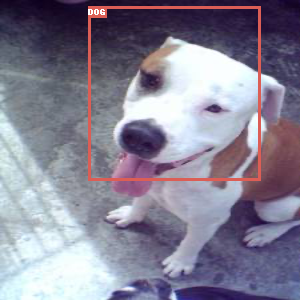

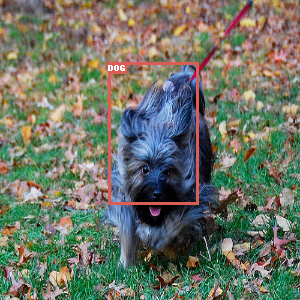

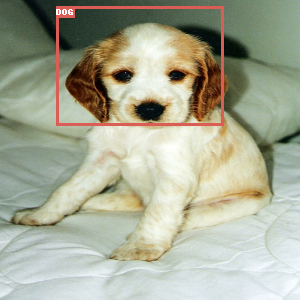

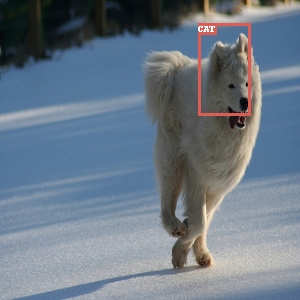

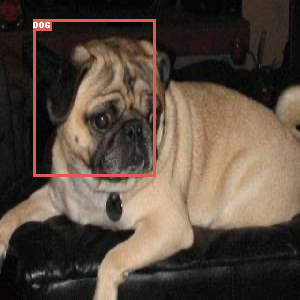

In [144]:
for i in range(images.shape[0]):
    display(draw_box(X_valid['new_path'].values[i], 
                     boxes_preds[i].tolist(), 
                     classes_preds.indices.tolist()[i], 
                     class_num_to_name))